In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical

import os
from PIL import Image

In [29]:
def convert_image_format(folder_path, from_format, to_format):
    """
    Convert all images in a folder from one format to another.
    
    Args:
    - folder_path (str): Path to the folder containing images.
    - from_format (str): Current image format (e.g., 'png').
    - to_format (str): Desired image format (e.g., 'jpg').
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.' + from_format):
            try:
                img = Image.open(os.path.join(folder_path, filename))
                if img.mode == 'RGBA':
                    img = img.convert('RGB')
                new_filename = filename.rsplit('.', 1)[0] + '.' + to_format
                img.save(os.path.join(folder_path, new_filename))
                os.remove(os.path.join(folder_path, filename))
            except Exception as e:
                continue

In [25]:
def remove_corrupted_image(folder_path):
    """
    Remove all corrupted images in a folder.

    Args:
    - folder_path (str): Path to the folder containing images.
    """
    num_skipped = 0
    for folder_name in ("CombWrench", "Hammer", "Screwdriver", "Wrench"):
        folder_path = os.path.join(folder_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = b"JFIF" in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

    print(f"Deleted {num_skipped} images.")

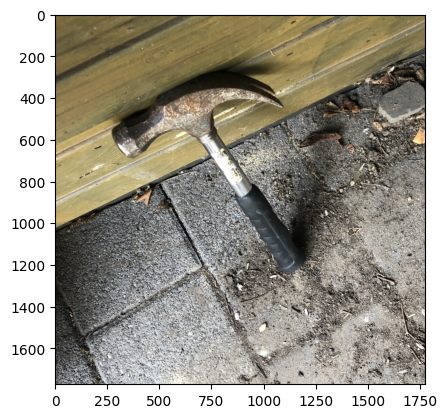

In [30]:
img = cv2.imread("Data//Real/Hammer/IMG_0655.JPEG")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [89]:
data = tf.keras.utils.image_dataset_from_directory("Data/Real/") # Load 32 images
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 203 files belonging to 4 classes.


In [90]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [91]:
# Class 0: COMBWRENCH
# Class 1: HAMMER
# Class 2: SCREWDRIVER
# Class 3: WRENCH
batch[1]

array([3, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 3, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 3, 1, 1, 3, 2])

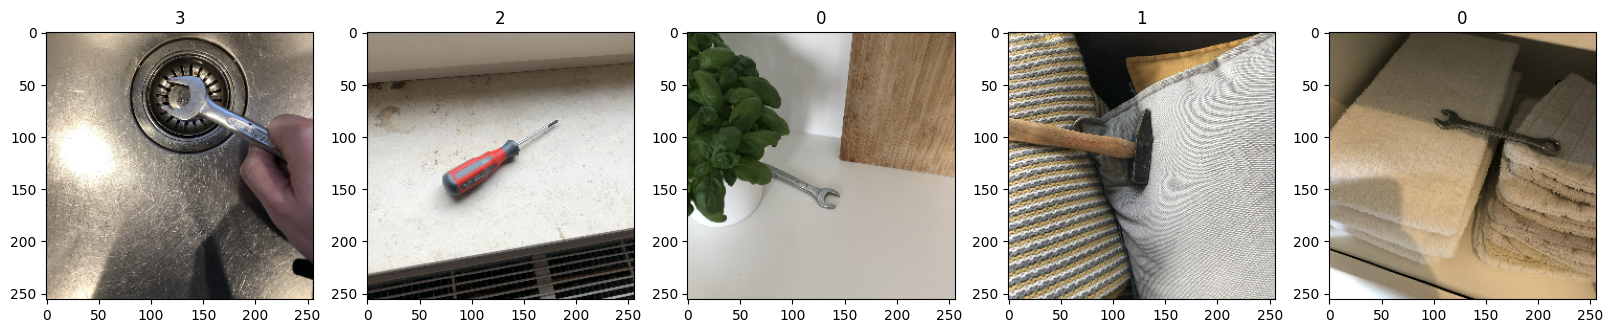

In [92]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocess Data

In [93]:
data = data.map(lambda x, y: (x/255, to_categorical(y, num_classes=4)))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

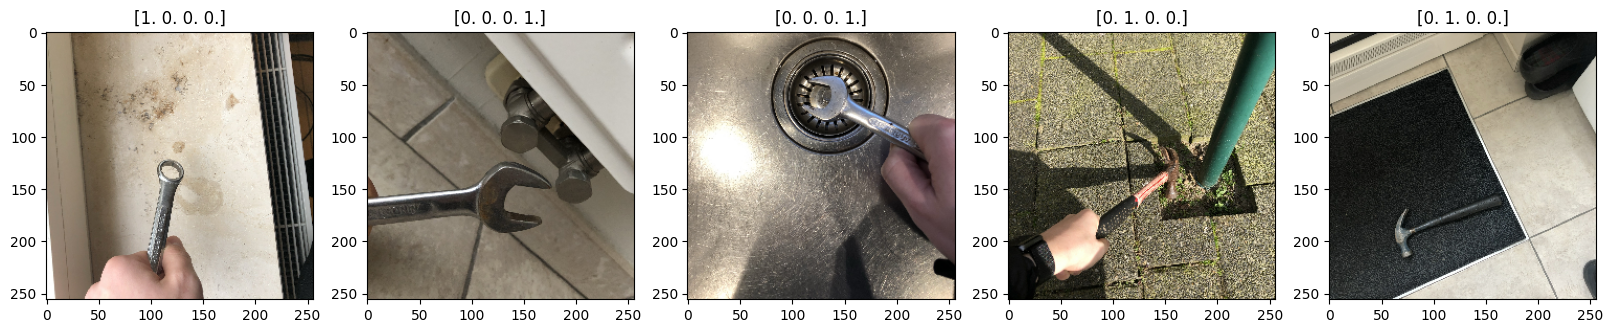

In [94]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [95]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1) + 1

In [96]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [97]:
# Validation set of real images.
valData = tf.keras.utils.image_dataset_from_directory("Data/Real/")
valData = valData.map(lambda x, y: (x/255, to_categorical(y, num_classes=4)))

Found 203 files belonging to 4 classes.


# Neural Network

In [98]:
model = Sequential()

In [99]:
# Filters: 16
# Filter Size: (3,3)
# Filter Move: 1
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [100]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Neural Network (Training)

In [104]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9240 - loss: 0.1928 - val_accuracy: 0.9375 - val_loss: 0.1563
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9156 - loss: 0.1809 - val_accuracy: 0.9531 - val_loss: 0.1307
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.9167 - loss: 0.1460 - val_accuracy: 0.9219 - val_loss: 0.1361
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.9312 - loss: 0.1298 - val_accuracy: 0.9844 - val_loss: 0.0967
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.9479 - loss: 0.0939 - val_accuracy: 0.9844 - val_loss: 0.0632
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9854 - loss: 0.0667 - val_accuracy: 1.0000 - val_loss: 0.0691
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.9865 - loss: 0.0516 - val_accuracy: 1.0000 - val_loss: 0.0584
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.9854 - loss: 0.0616 - val_accuracy: 1.0000 - val_loss:

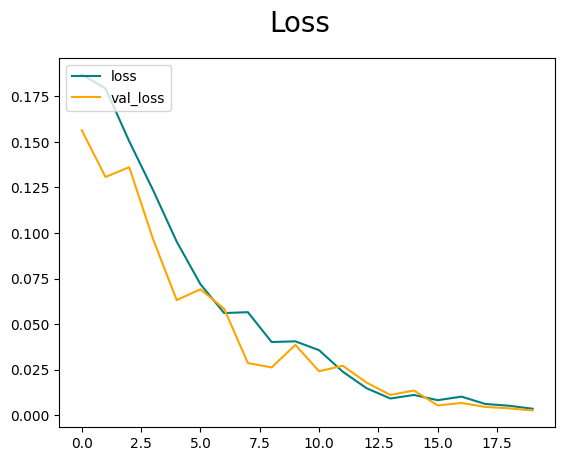

In [105]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

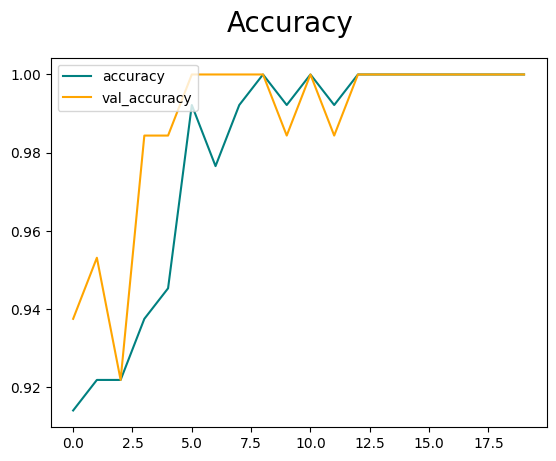

In [106]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluation

In [107]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [108]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [109]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{pre.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# Evaluation (Testing)

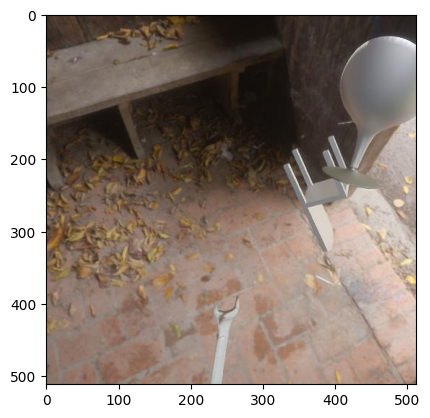

In [111]:
# img = cv2.imread("data/Hammer/IMG_0676.JPEG")
# img = cv2.imread("data/Screwdriver/IMG_0527.JPEG")

# img = cv2.imread("data/CombWrench/IMG_0626.JPEG")
# img = cv2.imread("data/CombWrench/IMG_0601.JPEG")
# img = cv2.imread("data/Wrench/IMG_0578.JPEG")

img = cv2.imread("Data/Synthetic/CombWrench/909_img.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

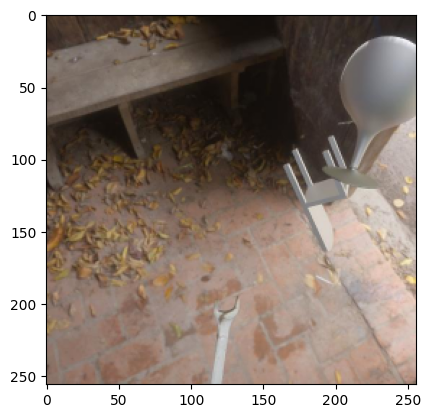

In [112]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [113]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [114]:
np.argmax(yhat)

0

# Save model

In [115]:
model.save(os.path.join("models", "Only_Real.keras"))